# Notebook de Ilyas Chahed et Mohamed Saidi


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import networkx as nx

In [ ]:
from torch_scatter import scatter_mean
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html

#Introduction
##Classification of Academic Articles with Graph Neural Networks (GNN)
Datasets in the field of machine learning (ML) are not always conventional tabular datasets. Some exhibit complex structures, such as citation networks in the academic domain. This project explores the use of Graph Neural Networks (GNN) for the classification of academic articles, with a specific focus on the well-known Cora dataset.

##Objective
The main goal is to explore and compare the performance of Graph Neural Networks with a traditional classification model. We employ a GNN to predict the topic of an article based on its words and citation network.

##Notebook Content
Graph Neural Network Implementation: We present an implementation of a Graph Neural Network (GNN), built from scratch for better understanding.

Comparison with a Traditional Model: We compare the performance of the GNN with a traditional classification model.

The ultimate aim is to demonstrate the effectiveness of GNNs in the classification of academic articles while providing an in-depth understanding of how a graph convolutional layer operates.

##Dataset Choice and Document Conversion
In this project, we have chosen the Cora dataset due to its citation network structure for academic articles. This choice is motivated by the availability of structured data on articles, offering a practical alternative to PDF documents that may not always be easily accessible online. The nature of the Cora dataset allows us to explore the capabilities of Graph Neural Networks (GNN) in the context of article classification.

Additionally, to extend the applicability of the techniques presented to other domains, we provide code within this notebook to convert any document into a binary vector representation. This functionality allows the application of the classification methods discussed here to domains where structured data is not directly available. You can find the relevant code at the end of the notebook, facilitating the conversion and classification of documents in various contexts.

## Setup

## Prepare the Dataset

The Cora dataset consists of 2,708 scientific papers classified into one of seven classes.
The citation network consists of 5,429 links. Each paper has a binary word vector of size
1,433, indicating the presence of a corresponding word.

### Download the dataset

The dataset has two tap-separated files: `cora.cites` and `cora.content`.

1. The `cora.cites` includes the citation records with two columns:
`cited_paper_id` (target) and `citing_paper_id` (source).
2. The `cora.content` includes the paper content records with 1,435 columns:
`paper_id`, `subject`, and 1,433 binary features.

Let's download the dataset.

In [ ]:

import os
import torch
from torchvision.datasets.utils import download_url
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Specify the dataset URL and file path
url = "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz"
zip_file_path = "cora.tgz"

if not os.path.exists(zip_file_path):
    download_url(url, root=".", filename=zip_file_path, md5=None)


shutil.unpack_archive(zip_file_path, extract_dir=".")

data_dir = os.path.join(".", "cora")
citations = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep="\t", header=None, names=["target", "source"])


column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

print(papers.sample(5).T)

print(papers.subject.value_counts())

# Encode subjects into numerical labels
label_encoder = LabelEncoder()
papers["subject"] = label_encoder.fit_transform(papers["subject"])


Papers shape: (2708, 1435)
                            1414                   623   \
paper_id                  293974                 189856   
term_0                         0                      0   
term_1                         0                      0   
term_2                         0                      0   
term_3                         0                      0   
...                          ...                    ...   
term_1429                      0                      0   
term_1430                      0                      0   
term_1431                      1                      0   
term_1432                      0                      0   
subject    Probabilistic_Methods  Probabilistic_Methods   

                             3                      2161             2256  
paper_id                    13195                1134348          1112665  
term_0                          0                      0                0  
term_1                          0   

In [ ]:
citations.sample(frac=1, random_state=42).head()

,target,source
79,35,263498
3161,45605,503871
1643,9581,1130780
167,40,1114442
439,1365,22835


In [ ]:
print(papers.subject.value_counts())

2    818
3    426
1    418
6    351
0    298
4    217
5    180
Name: subject, dtype: int64


We convert the paper ids and the subjects into zero-based indices.

In [ ]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

Now let's visualize the citation graph. Each node in the graph represents a paper,
and the color of the node corresponds to its subject. Note that we only show a sample of
the papers in the dataset.

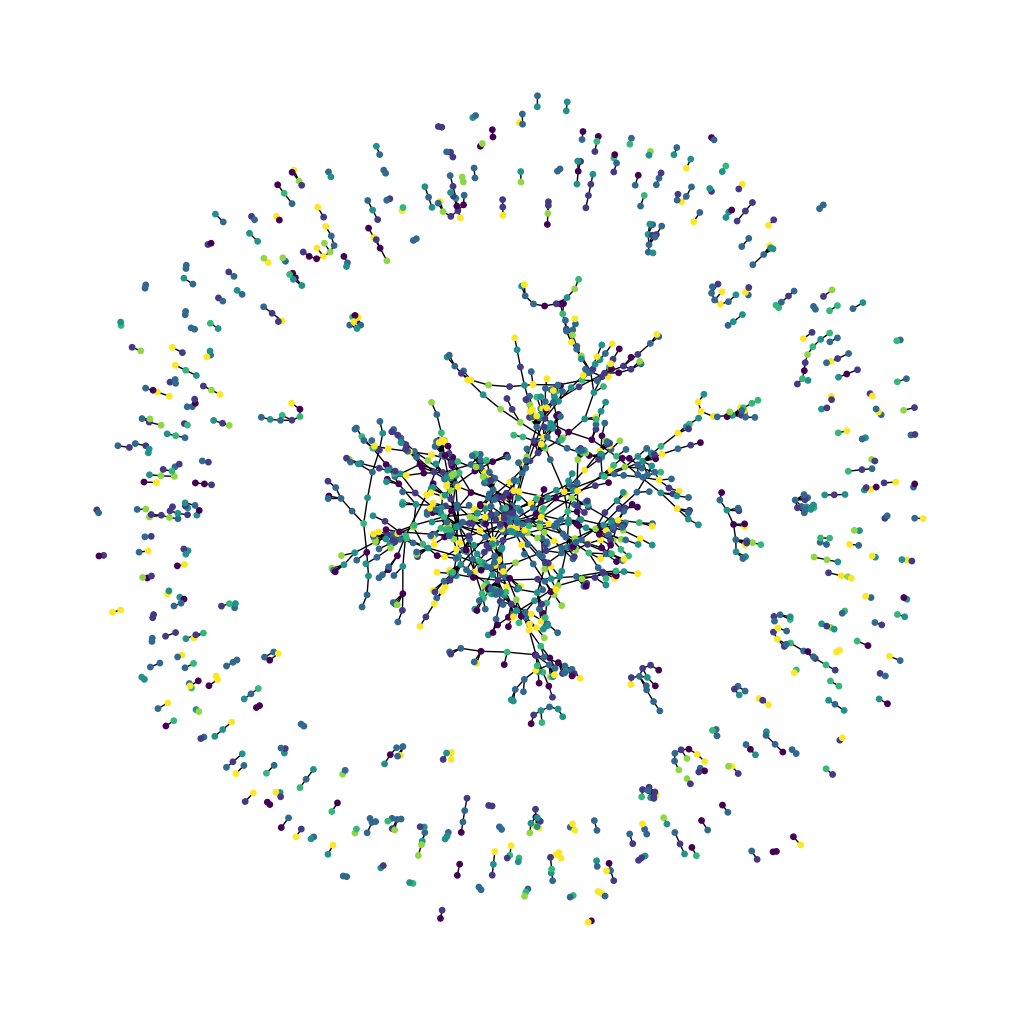

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


### Split the dataset into stratified train and test sets

In [ ]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1386, 1435)
Test data shape: (1322, 1435)


In [ ]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

<ipython-input-65-5d9edcd08e3d>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[feature_names].to_numpy()
<ipython-input-65-5d9edcd08e3d>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[feature_names].to_numpy()


#Hyperparameter definition

In [ ]:
hidden_units = [32, 32]
learning_rate = 0.001
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

## Implement Train and Evaluate Experiment

## Build a Baseline Neural Network Model

In [ ]:
y_test.sample(10)

925     2
942     1
546     1
160     2
2389    3
608     2
2054    6
1974    2
471     4
1212    0
Name: subject, dtype: int64

In [ ]:
import torch
import torch.nn as nn

class ModifiedFFNBlock(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, weight_decay):
        super(ModifiedFFNBlock, self).__init__()
        self.ffn = nn.Sequential(
            nn.Linear(input_size, hidden_size,weight_decay),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, hidden_size,weight_decay),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.BatchNorm1d(hidden_size)
        )

    def forward(self, x):
        return self.ffn(x)

class BaselineModel(nn.Module):
    def __init__(self, num_features, hidden_units, num_classes, dropout_rate=0.2, weight_decay=1e-5):
        super(BaselineModel, self).__init__()
        self.input_layer = nn.Linear(num_features, hidden_units[0])
        self.ffn_blocks = nn.ModuleList([
            ModifiedFFNBlock(hidden_units[0], hidden_units[1], dropout_rate, weight_decay)
            for i in range(4)
        ])
        self.logits_layer = nn.Linear(hidden_units[-1], num_classes)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))

        for ffn_block in self.ffn_blocks:
            x1 = ffn_block(x)
            x = x + x1

        logits = self.logits_layer(x)
        return logits


In [ ]:
baseline_model = BaselineModel(num_features, hidden_units, num_classes, dropout_rate=0.7)

#### Addressing Overfitting with Dropout

During the training of our Baseline model, we encountered the issue of overfitting.
To mitigate the overfitting problem, we decided to incorporate a dropout layer into our architecture. This helps prevent the model from relying too heavily on specific neurons, promoting a more robust generalization to unseen data.


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [6 3 0 ... 2 0 6]
Epoch [1/300], Train Loss: 2.3860, Train Acc: 0.1655, Val Loss: 1.9309, Val Acc: 0.1394
Epoch [2/300], Train Loss: 2.3427, Train Acc: 0.1418, Val Loss: 1.8960, Val Acc: 0.3462
Epoch [3/300], Train Loss: 2.2540, Train Acc: 0.1740, Val Loss: 1.8739, Val Acc: 0.3317
Epoch [4/300], Train Loss: 2.1675, Train Acc: 0.1740, Val Loss: 1.8550, Val Acc: 0.3317
Epoch [5/300], Train Loss: 2.0979, Train Acc: 0.1935, Val Loss: 1.8390, Val Acc: 0.3317
Epoch [6/300], Train Loss: 2.0417, Train Acc: 0.2165, Val Loss: 1.8256, Val Acc: 0.3317
Epoch [7/300], Train Loss: 2.0223, Train Acc: 0.2207, Val Loss: 1.8132, Val Acc: 0.3317
Epoch [8/300], Train Loss: 1.9964, Train Acc: 0.2334, Val Loss: 1.8018, Val Acc: 0.3317
Epoch [9/300], Train Loss: 1.9658, Train Acc: 0.2564, Val Loss: 1.7894, Val Acc: 0.3317
Epoch [10/300], Train Loss: 1.9227

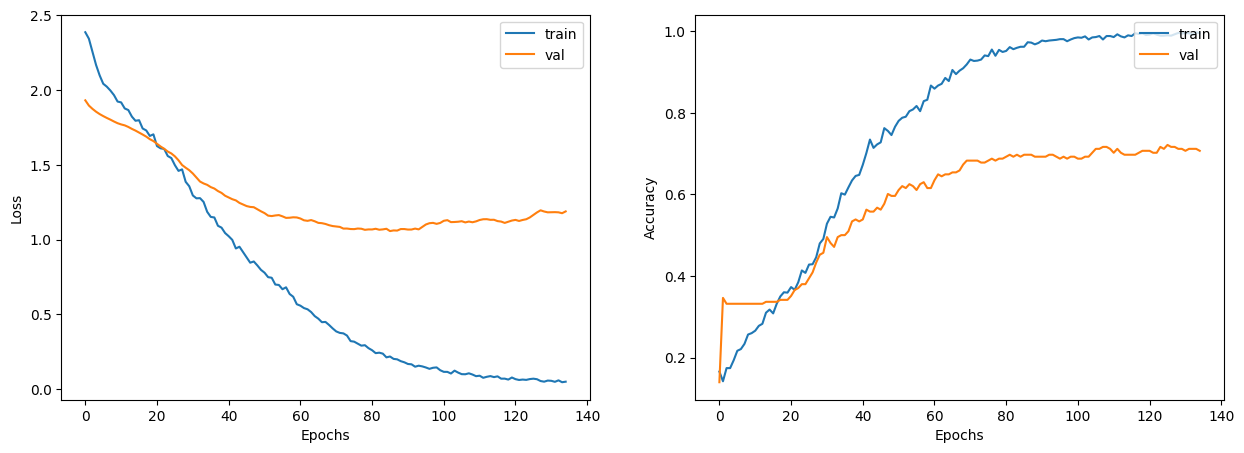

In [ ]:
###Train with early stopping
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def run_experiment(model, x_train, y_train, validation_split=0.15, learning_rate=0.002, num_epochs=300, batch_size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_loss = float('inf')
    patience = 50
    current_patience = 0

    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.long)

    x_train, x_val, y_train, y_val = train_test_split(x_train.numpy(), y_train.numpy(), test_size=validation_split)
    print( x_train, y_train)

    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)


    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []


    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            train_loss += loss.item()


        train_accuracy = correct_train / len(train_loader.dataset)
        train_loss /= len(train_loader)


        model.eval()
        val_loss, correct_val = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                val_loss += loss.item()

        # Calculate validation accuracy and loss
        val_accuracy = correct_val / len(val_loader.dataset)
        val_loss /= len(val_loader)
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          current_patience = 0
        else:
          current_patience += 1
          if current_patience == patience:
              print("Early stopping. No improvement in validation loss.")
              break


        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Store history for later analysis
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)

    # Display learning curves
    display_learning_curves(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def display_learning_curves(train_loss_history, train_acc_history, val_loss_history, val_acc_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_loss_history, label='train')
    ax1.plot(val_loss_history, label='val')
    ax1.legend(loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(train_acc_history, label='train')
    ax2.plot(val_acc_history, label='val')
    ax2.legend(loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")

    plt.show()


train_loss, train_acc, val_loss, val_acc = run_experiment(baseline_model, x_train, y_train)


In [ ]:
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test.values))
test_loader = DataLoader(test_dataset, batch_size=batch_size)

baseline_model.eval()  # Set the model to evaluation mode
correct_test = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = baseline_model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()

test_accuracy = correct_test / len(test_loader.dataset)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.0%


####Baseline Model Accuracy

The baseline model achieved a test accuracy of 73.0%.  In the context of our classification task using the Cora dataset, a 73.0% accuracy serves as a reference point for evaluating the effectiveness of subsequent model improvements.
73.0% accuracy is a reasonable starting point.



## Summary: Random Instance Generation and Class Probability Display

The provided code defines two functions:

### 1. `generate_random_instances(num_instances)`

This function generates a specified number of random instances based on token probabilities derived from the training data. The process involves sampling random probabilities and creating instances where each token is included based on these probabilities. The resulting instances are returned as a torch tensor.

### 2. `display_class_probabilities(probabilities)`

This function takes a tensor of class probabilities for different instances and displays the probabilities for each class.
These functions can be useful for understanding the model's behavior and exploring its predictions on randomly generated instances.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np


def generate_random_instances(num_instances):
    token_probability = torch.mean(torch.tensor(x_train, dtype=torch.float32), dim=0)
    instances = []
    for _ in range(num_instances):
        probabilities = torch.rand(size=(len(token_probability),))
        instance = (probabilities <= token_probability).float()
        instances.append(instance)

    return torch.stack(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob.item() * 100, 2)}%")


In [ ]:
new_instances = generate_random_instances(num_classes)

baseline_model.eval()  # Set the model to evaluation mode
logits = baseline_model(new_instances)
probabilities = F.softmax(logits, dim=1).detach().numpy()
display_class_probabilities(probabilities)

Instance 1:
- 0: 2.29%
- 1: 96.41%
- 2: 0.56%
- 3: 0.01%
- 4: 0.72%
- 5: 0.01%
- 6: 0.01%
Instance 2:
- 0: 1.74%
- 1: 1.18%
- 2: 0.55%
- 3: 0.48%
- 4: 81.45%
- 5: 14.44%
- 6: 0.17%
Instance 3:
- 0: 2.28%
- 1: 58.37%
- 2: 1.71%
- 3: 0.97%
- 4: 12.8%
- 5: 18.15%
- 6: 5.72%
Instance 4:
- 0: 0.73%
- 1: 0.99%
- 2: 88.62%
- 3: 0.82%
- 4: 1.72%
- 5: 1.75%
- 6: 5.37%
Instance 5:
- 0: 4.85%
- 1: 95.01%
- 2: 0.0%
- 3: 0.0%
- 4: 0.13%
- 5: 0.0%
- 6: 0.01%
Instance 6:
- 0: 5.59%
- 1: 2.85%
- 2: 12.09%
- 3: 31.24%
- 4: 9.86%
- 5: 20.35%
- 6: 18.02%
Instance 7:
- 0: 4.44%
- 1: 0.95%
- 2: 4.07%
- 3: 4.16%
- 4: 23.43%
- 5: 35.65%
- 6: 27.31%


## Summary: Graph Creation for GNN

The provided code initializes the necessary components for creating a graph that will be used in the Graph Neural Network (GNN) model:

### Graph Components:
1. **Edges Array:**
   - Created from the "source" and "target" columns of the 'citations' DataFrame.
   - Represents the connections between nodes in the graph.

2. **Edge Weights Array:**
   - Initialized with all values set to 1.
   - Represents uniform weights for edges in the graph.

3. **Node Features Array:**
   - Constructed from selected feature columns of the 'papers' DataFrame.
   - Represents the features associated with each node in the graph.





In [ ]:
import torch



# Creating Edges Array
edges = citations[["source", "target"]].to_numpy().T

# Creating Edge Weights Array
edge_weights = torch.ones(edges.shape[1])

# Creating Node Features Array
node_features = torch.tensor(
    papers.sort_values("paper_id")[feature_names].to_numpy(),
    dtype=torch.float32
)

# Creating Graph Info Tuple
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: torch.Size([2708, 1433])
Nodes shape: torch.Size([2708, 1433])


<ipython-input-77-87a3ceef3cfc>:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  papers.sort_values("paper_id")[feature_names].to_numpy(),


## Summary: GNN Model and Training Experiment

The code includes the definition of a Graph Neural Network (GNN) model and an experiment setup for training and evaluation.

### GNN Model:
   - **FeedForwardNetwork:** Implements a feedforward neural network with batch normalization, dropout, linear layers, and GELU activation.
   - **GraphConvLayer:** Defines a graph convolutional layer with customizable aggregation and combination strategies.
   - **GNNNodeClassifier:** Combines graph convolution layers to create a node classifier with preprocessing, convolution, and post-processing.

### Experiment Setup:
   - Splits data into training and validation sets using PyTorch DataLoader.
   - Utilizes cross-entropy loss and Adam optimizer for training.
   - Implements a training loop with early stopping to prevent overfitting.
   - Tracks and displays training and validation accuracy, along with loss.

### Execution:
   - The experiment runs for a specified number of epochs, learning rate, and batch size.
   - Learning curves visualize the model's training progress.

This code provides a flexible and comprehensive setup for training and evaluating a GNN-based node classifier.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardNetwork(nn.Module):
    def __init__(self, input_size, hidden_units, dropout_rate):
        super(FeedForwardNetwork, self).__init__()
        layers = []
        for units in hidden_units:
            layers.append(nn.BatchNorm1d(input_size))
            layers.append(nn.Dropout(p=dropout_rate))
            layers.append(nn.Linear(input_size, units))
            layers.append(nn.GELU())
            input_size = units

        self.ffn = nn.Sequential(*layers)

    def forward(self, x):
        return self.ffn(x)

class GraphConvLayer(nn.Module):
    def __init__(self, input_size, hidden_units, dropout_rate=0.3, aggregation_type="mean", combination_type="concat", normalize=False):
        super(GraphConvLayer, self).__init__()
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = FeedForwardNetwork(input_size, hidden_units, dropout_rate)

        if self.combination_type == "gated":
            self.update_fn = nn.GRU(
                input_size,
                hidden_units[0],
                batch_first=True,
                dropout=dropout_rate,
            )
        else:
            self.update_fn = FeedForwardNetwork(64, hidden_units, dropout_rate)

    def prepare(self, node_representations, weights=None):
        messages = self.ffn_prepare(node_representations)
        if weights is not None:
            messages = messages * weights.unsqueeze(-1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        #print('neighbour_messages.shape', neighbour_messages.shape, 'node_indices', node_indices.shape, 'num_nodes', num_nodes)

        if self.aggregation_type == "sum":
            aggregated_message = scatter_sum(
                neighbour_messages, node_indices, dim=0, dim_size=num_nodes
            )
        elif self.aggregation_type == "mean":

            aggregated_message = scatter_mean(
                neighbour_messages, torch.tensor(node_indices), dim=0, dim_size=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message, _ = scatter_max(
                neighbour_messages, node_indices, dim=0, dim_size=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_representations, aggregated_messages):
        #h = torch.cat([node_representations, aggregated_messages], dim=1)

        if self.combination_type == "gru":
            h = torch.stack([node_representations, aggregated_messages], dim=1)
            #print('gru', h)
            #_, node_embeddings = self.update_fn(h.unsqueeze(0))
            #node_embeddings = node_embeddings.squeeze(0)
        elif self.combination_type == "concat":
            h = torch.cat([node_representations, aggregated_messages], dim=1)
            #print('concat', h)
            #node_embeddings = h
        elif self.combination_type == "add":
            h = node_representations + aggregated_messages
            #print('add', h)
            #node_embeddings = node_representations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")



        node_embeddings = self.update_fn(h)
        #print('update_fn', node_embeddings)
        if self.combination_type == "gru":
            # Unstack if GRU and select the last element
            node_embeddings = node_embeddings.unbind(dim=1)[-1]

        if self.normalize:
            # L2 normalize along the last dimension
            node_embeddings = torch.nn.functional.normalize(node_embeddings, p=2, dim=-1)


        #print('Zab',node_embeddings.shape)

        return node_embeddings



    def forward(self, node_representations, edges, edge_weights):
        node_indices, neighbour_indices = edges[0], edges[1]

        #print('node_indices, neighbour_indices', node_indices, neighbour_indices)

        neighbour_representations = node_representations[neighbour_indices]
        #print('NR',node_representations, 'NR2')
        ###print('AAAAA',neighbour_messages.dtype)
        neighbour_messages = self.prepare(neighbour_representations, edge_weights)

        aggregated_messages = self.aggregate(node_indices, neighbour_messages, node_representations)

        #print('AGGGGG',aggregated_messages, 'AGGGG')
        #print('AGGGGG',neighbour_messages, node_representations, 'AGGGG')
        node_embeddings = self.update(node_representations, aggregated_messages)
        ##print('EEEEEE',node_embeddings.shape)
        #print('N3',node_embeddings, 'NR4')

        return node_embeddings

class GNNNodeClassifier(nn.Module):
    def __init__(self, graph_info, num_classes, hidden_units, dropout_rate=0.2, name="gnn_model"):
        super(GNNNodeClassifier, self).__init__()

        self.graph_info = graph_info
        self.num_classes = num_classes
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate

        input_size = graph_info[0].shape[1]

        self.preprocess = FeedForwardNetwork(input_size, hidden_units, dropout_rate)
        self.conv1 = GraphConvLayer(32, hidden_units, dropout_rate)
        self.conv2 = GraphConvLayer(32, hidden_units, dropout_rate)
        self.postprocess = FeedForwardNetwork(32, hidden_units, dropout_rate)
        self.compute_logits = nn.Linear(32, num_classes)

    def forward(self, input_node_indices):
        input_node_indices = torch.tensor(input_node_indices, dtype=torch.long)
        node_features, edges, edge_weights = self.graph_info
        #print('AAAA', node_features.shape, edges.shape, edge_weights)
        #print("Input Size:", node_features.size())

        x = self.preprocess(node_features)
        #print("After Preprocess Size:", x.size())
        #print("After Preprocess Size:", x)

        x1 = self.conv1(x, edges, edge_weights)
        #print("After Conv1 Size:", x1)

        x = x1 + x

        x2 = self.conv2(x, edges, edge_weights)
        #print("After Conv2 Size:", x2)

        x = x2 + x

        x = self.postprocess(x)
        """ print("After Postprocess Size:", x.size())

        print('YARBI', len(input_node_indices))"""



        node_embeddings = x[input_node_indices]


        logits = self.compute_logits(node_embeddings)
        #print("Logits Size:", logits.size())

        return logits



def run_experiment(model, x_train, y_train, validation_split=0.15, learning_rate=0.01, num_epochs=300, batch_size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_loss = float('inf')
    patience = 50
    current_patience = 0
    # Convert to PyTorch tensors directly
    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.long)

    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train.numpy(), y_train.numpy(), test_size=validation_split)
    print( x_train, y_train)
    # Convert to PyTorch DataLoader
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Define the loss function, optimizer, and move the model to the device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)

    # Create lists to store training and validation history
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train = 0, 0

        for inputs, labels in train_loader:
            #print("inputs= ",inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            #print("outputs= ",outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            train_loss += loss.item()

        # Calculate training accuracy and loss
        train_accuracy = correct_train / len(train_loader.dataset)
        train_loss /= len(train_loader)

        # Validation loop
        model.eval()
        val_loss, correct_val = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                val_loss += loss.item()

        val_accuracy = correct_val / len(val_loader.dataset)
        val_loss /= len(val_loader)
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          current_patience = 0
        else:
          current_patience += 1
          if current_patience == patience:
              print("Early stopping. No improvement in validation loss.")
              break


        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)

    # Display learning curves
    display_learning_curves(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

"""gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)
gnn_model([1, 10, 100])
x_train = torch.tensor(train_data.paper_id.to_numpy(), dtype=torch.long)
history = run_experiment(gnn_model, x_train, y_train)"""

'gnn_model = GNNNodeClassifier(\n    graph_info=graph_info,\n    num_classes=num_classes,\n    hidden_units=hidden_units,\n    dropout_rate=dropout_rate,\n    name="gnn_model",\n)\ngnn_model([1, 10, 100])\nx_train = torch.tensor(train_data.paper_id.to_numpy(), dtype=torch.long)\nhistory = run_experiment(gnn_model, x_train, y_train)'

#Instantiation

In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)
gnn_model([1, 10, 100])

tensor([[-0.2011,  0.1144,  0.2526,  0.0882, -0.3480, -0.1988, -0.2305],
        [ 0.0778, -0.0458,  0.0083, -0.1565, -0.0160, -0.0134, -0.0931],
        [ 0.2839,  0.0999,  0.3045, -0.1449, -0.0480, -0.0455,  0.0908]],
       grad_fn=<AddmmBackward0>)

<ipython-input-184-2a30c09d10ec>:191: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
<ipython-input-184-2a30c09d10ec>:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_node_indices = torch.tensor(input_node_indices, dtype=torch.long)


[1301.  229.  904. ... 1095. 2638. 2308.] [2 6 2 ... 3 6 4]
Epoch [1/300], Train Loss: 1.9010, Train Acc: 0.2521, Val Loss: 1.8596, Val Acc: 0.3462
Epoch [2/300], Train Loss: 1.8506, Train Acc: 0.2784, Val Loss: 1.8147, Val Acc: 0.3462
Epoch [3/300], Train Loss: 1.8592, Train Acc: 0.2886, Val Loss: 1.8167, Val Acc: 0.3462
Epoch [4/300], Train Loss: 1.8510, Train Acc: 0.2844, Val Loss: 1.8305, Val Acc: 0.3462
Epoch [5/300], Train Loss: 1.8220, Train Acc: 0.2869, Val Loss: 1.8468, Val Acc: 0.3462
Epoch [6/300], Train Loss: 1.8145, Train Acc: 0.2895, Val Loss: 1.8591, Val Acc: 0.3462
Epoch [7/300], Train Loss: 1.7743, Train Acc: 0.2912, Val Loss: 1.8606, Val Acc: 0.2981
Epoch [8/300], Train Loss: 1.7430, Train Acc: 0.2937, Val Loss: 1.8480, Val Acc: 0.2885
Epoch [9/300], Train Loss: 1.7225, Train Acc: 0.3200, Val Loss: 1.8025, Val Acc: 0.3173
Epoch [10/300], Train Loss: 1.6778, Train Acc: 0.3234, Val Loss: 1.6881, Val Acc: 0.3317
Epoch [11/300], Train Loss: 1.6318, Train Acc: 0.3710, Val 

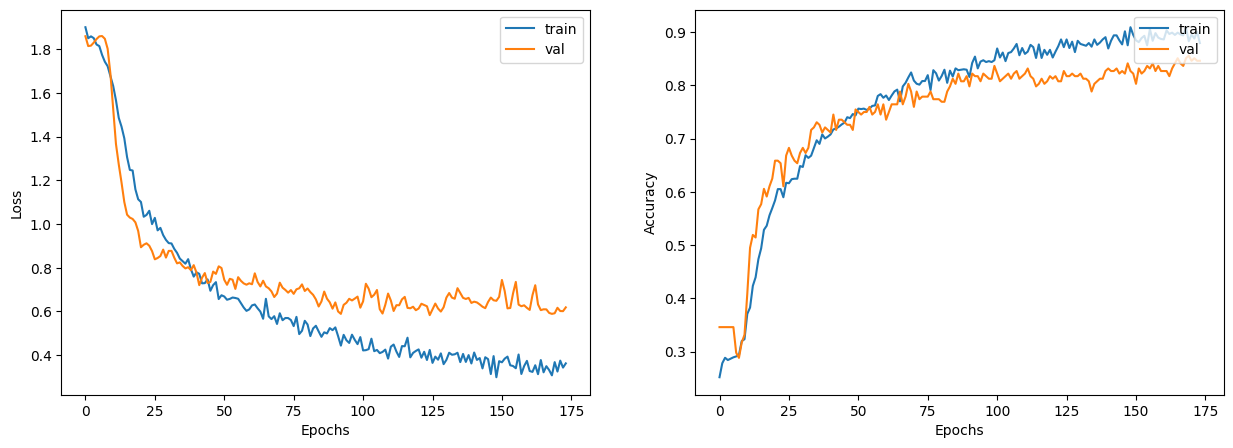

In [ ]:
x_train = torch.tensor(train_data.paper_id.to_numpy(), dtype=torch.float32)
history = run_experiment(gnn_model, x_train, y_train)

## GNN Model Test Accuracy
The test accuracy of 82.07% for the Graph Neural Network (GNN) model represents a notable improvement compared to the baseline accuracy of 73.0% achieved with a simple Multilayer Perceptron (MLP) model.

The higher accuracy is a promising result and reflects the effectiveness of the GNN architecture in this context.


In [ ]:
import torch

gnn_model.eval()

x_test_tensor = torch.tensor(test_data.paper_id.to_numpy(), dtype=torch.float32)

with torch.no_grad():
    predictions = gnn_model(x_test_tensor)



y_test_tensor = torch.tensor(y_test, dtype=torch.long)  # Adjust the dtype as needed

# Calculate accuracy
correct_predictions = (torch.argmax(predictions, dim=1) == y_test_tensor).sum().item()
total_samples = len(y_test)

test_accuracy = correct_predictions / total_samples

print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 82.07%


<ipython-input-184-2a30c09d10ec>:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_node_indices = torch.tensor(input_node_indices, dtype=torch.long)
